In [2]:
import matplotlib.pyplot as plt
from imblearn.datasets import make_imbalance
from sklearn.metrics import classification_report
import numpy as np

from qore_sdk.utils import sliding_window
from qore_sdk.featurizer import Featurizer
from qore_sdk.client import WebQoreClient

from dataloader import load_dataset

# 取得したアカウント情報の読み込み
from credentials import username, password, endpoint

%matplotlib inline

In [3]:
# データセットのダウンロード
# X_train, X_test, y_train, y_test = load_dataset()
# print('X_train.shape:', X_train.shape)
# print('X_test.shape:', X_test.shape)

In [22]:
# print('X_train.shape:', X_train.shape)
# print('X_test.shape:', X_test.shape)
# print('y_train.shape:', y_train.shape)
# print('y_test.shape:', y_test.shape)
# type(X_train)

# idx_n = np.where(y_train == 0)[0]
# plt.plot(X_train[idx_n[0]])

# idx_s = np.where(y_train == 1)[0]
# plt.plot(X_train[idx_s[0]])

In [53]:
t_length = 3000
t_width = 400

train_x = np.arange(t_length)
# 平均がsin(x), 分散0.1の正規分布に従う配列を生成
train_y = np.random.normal(np.sin(2 * np.pi * train_x / 100), 0.1)
x = []
y = []
for i in range(len(train_x) - t_width):
    x.append(train_y[i:i + t_width])
    y.append(train_y[i + t_width])

x = np.array(x)
y = np.array(y)
# print(x.shape)
# print(y.shape)

X_train = x[0:(t_length // 2)]
X_test = x[(t_length // 2):]
y_train = y[0:(t_length // 2)]
y_test = y[(t_length // 2):]

print(X_train.shape)
print(X_test.shape)

width = 100
stepsize = 8
n_filters = 8

# ここで(サンプル数, 時系列長, 小時系列長)の配列を作成
X_train2 = sliding_window(X_train, width, stepsize)
X_test2 = sliding_window(X_test, width, stepsize)
print('X_train.shape:', X_train2.shape)
print('X_test.shape:', X_test2.shape)

# (サンプル数, 時系列長, 変量数)の配列に変換(Qoreへの入力となる)
featurizer = Featurizer(n_filters)
X_train2 = featurizer.featurize(X_train2, axis=2)
X_test2 = featurizer.featurize(X_test2, axis=2)
print(X_train2.shape, X_test2.shape)

(1500, 400)
(1100, 400)
X_train.shape: (1500, 38, 100)
X_test.shape: (1100, 38, 100)
(1500, 38, 8) (1100, 38, 8)


In [54]:
# 学習
client = WebQoreClient(username, password, endpoint=endpoint)
time_ = client.regression_train(X_train2, y_train)
print('Time:.', time_, 'min.')

Time:. {'res': 'ok', 'train_time': 4.611053943634033} min.


In [55]:
# 予測
res = client.regression_predict(X_test2)

0.9253309429777961


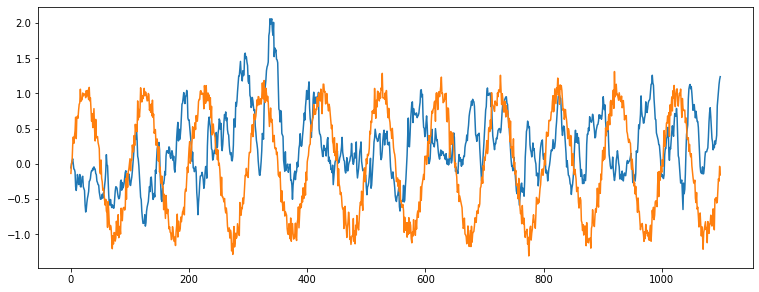

In [56]:
# 評価
from sklearn.metrics import mean_squared_error

plt.plot(res['Y'],  figure=plt.figure(figsize=(12.8, 4.8)))
plt.plot(y_test)

# 平均平方二乗誤差を求める(小さい方が良く予測できている)
rmse = np.sqrt(mean_squared_error(y_test, res['Y']))
print(rmse)

In [58]:
# TODO: 予測データを使って任意の時間tの予測をしたい
# ref. https://www.atmarkit.co.jp/ait/articles/1804/26/news150.html